# **Face Detection Using RetinaNet**

In [1]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3984, done.
remote: Counting objects: 100% (3984/3984), done.
remote: Compressing objects: 100% (3085/3085), done.
remote: Total 3984 (delta 1158), reused 1955 (delta 842), pack-reused 0
Receiving objects: 100% (3984/3984), 49.75 MiB | 24.78 MiB/s, done.
Resolving deltas: 100% (1158/1158), done.


In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing meta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.7.2 requires PyYAML>=5.4.1, but you have pyyaml 5.3.1 which is incompatible.
pydantic 2.2.0 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.6.0 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [29]:
def image_to_numpy_array(image_path):
  img_data = tf.io.gfile.GFile(image_path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (img_w, img_h) = image.size
  return np.array(image.getdata()).reshape((img_h, img_w, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  img_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      img_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.7
  )
  if image_name:
    plt.imsave(image_name, img_with_annotations)
  else:
    plt.imshow(img_with_annotations)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<function matplotlib.pyplot.show(close=None, block=None)>

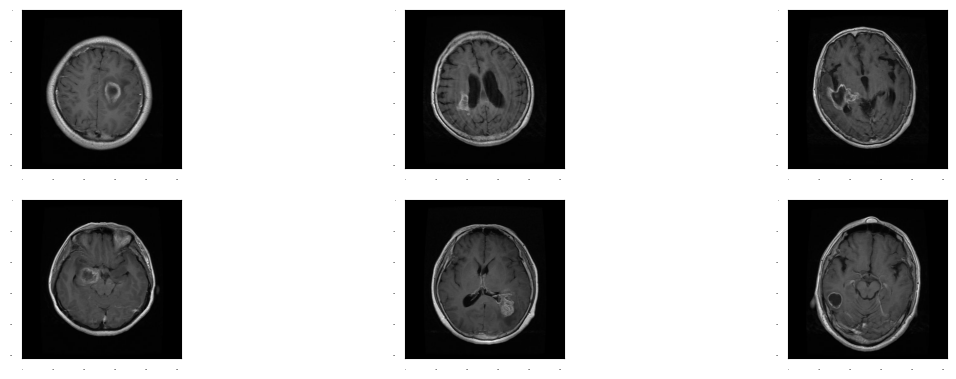

In [5]:
train_dir = '/content/drive/MyDrive/Brain Tumor Dataset/train/'
train_image_np = []
for filename in os.listdir(train_dir):
  image_path = os.path.join(train_dir, filename)
  train_image_np.append(image_to_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, img in enumerate(train_image_np):
  plt.subplot(3, 3, idx+1)
  plt.imshow(img)
plt.show

In [6]:
# ground truth boxes
gt_boxes = []
colab_utils.annotate(train_image_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [7]:
# in case the annotations are lost due to colab runtime disconnected and deleted
# gt_boxes = [
#     np.array([[0.35106771, 0.490625, 0.40940104, 0.5359375]], dtype=np.float32),
#     np.array([[0.26773438, 0.45, 0.36606771, 0.5078125]], dtype=np.float32),
#     np.array([[0.27106771, 0.446875, 0.36940104, 0.5078125]], dtype=np.float32),
#     np.array([[0.19773437, 0.4765625, 0.35773437, 0.5453125]], dtype=np.float32),
#     np.array([[0.15440104, 0.4453125, 0.33273438, 0.5140625]], dtype=np.float32),
#     np.array([[0.18940104, 0.459375, 0.33606771, 0.528125]], dtype=np.float32),
#     np.array([[0.14606771, 0.4078125, 0.31606771, 0.478125]], dtype=np.float32)
# ]

for coordinates in gt_boxes:
  print(coordinates)

[[0.4527662  0.51367188 0.5927662  0.62304688]]
[[0.51943287 0.33007812 0.63943287 0.40429688]]
[[0.4727662  0.26757812 0.6327662  0.42773438]]
[[0.42943287 0.36523438 0.5377662  0.47851562]]
[[0.59609954 0.578125   0.7377662  0.68554688]]
[[0.5927662  0.25       0.68109954 0.34375   ]]


In [11]:
num_classes = 1
id_offset = 1
category_index = {
    1: {"id": 1,
        "name": "tumor"}
}

train_image_tensors = []
gt_box_tensors = []
gt_classes_one_hot_tensors = []
for (train_img_np, gt_box_np) in zip(train_image_np, gt_boxes):

  # convert np array image to tensor
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_img_np, dtype=tf.float32), axis=0))

  # convert gt box np array to tensor without adding extra batch dim
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

  # create one-hot ground truth class labels
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))

In [12]:
print(zero_indexed_groundtruth_classes)
print(gt_classes_one_hot_tensors)

tf.Tensor([0], shape=(1,), dtype=int32)
[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>]


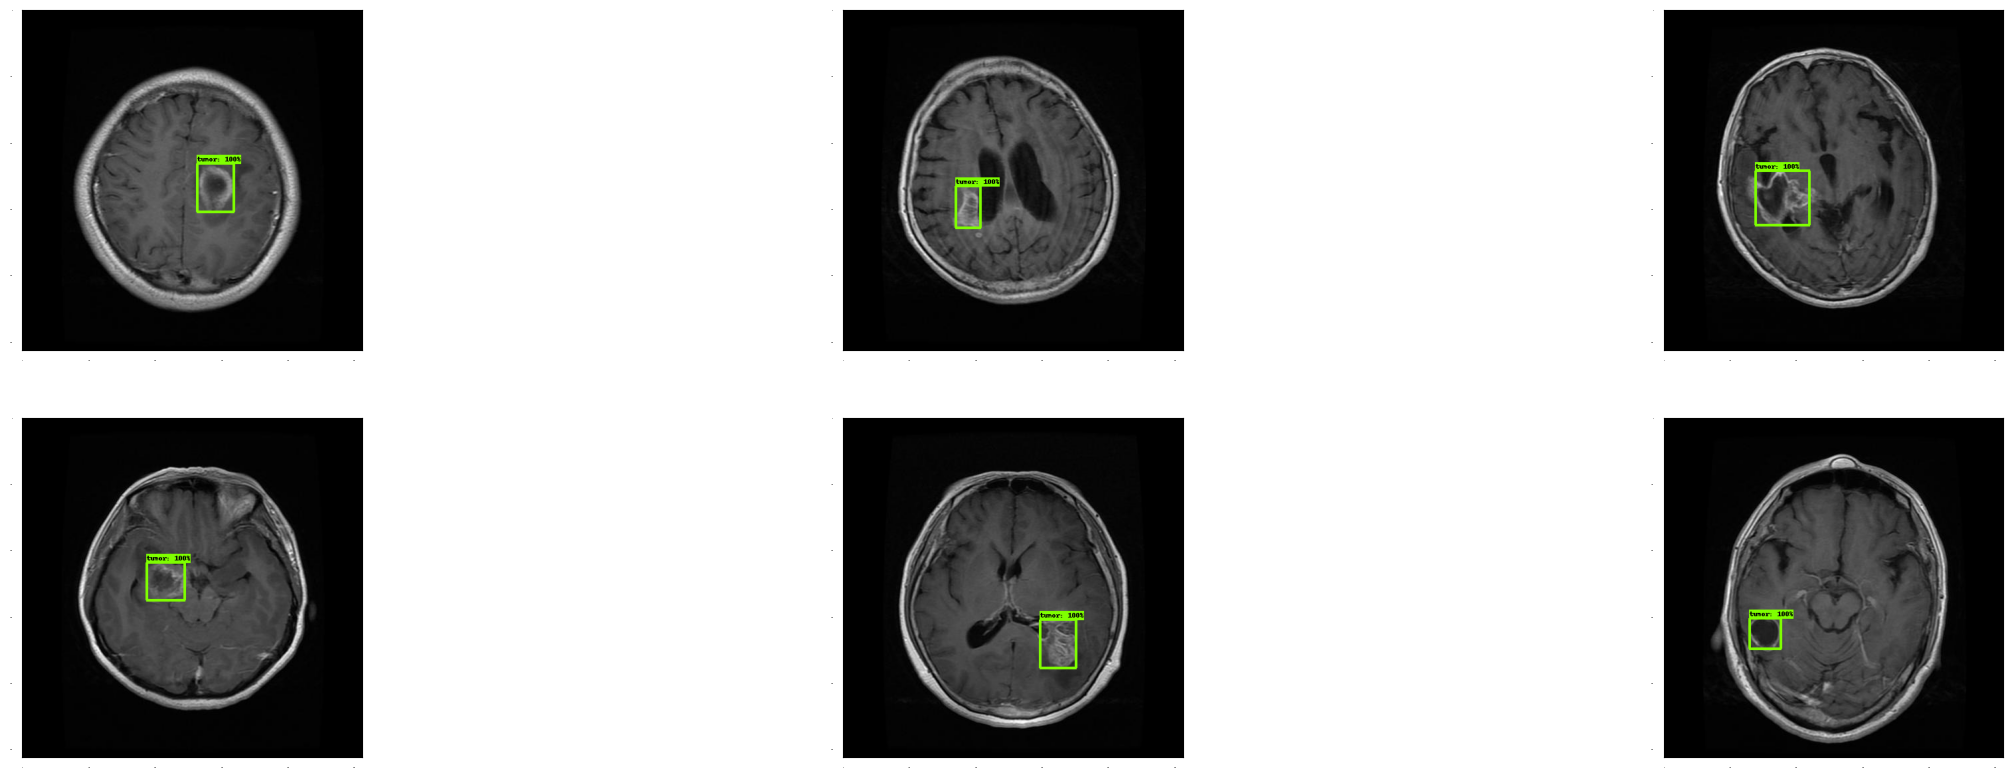

In [13]:
# visualize images as sanity check
plt.figure(figsize=(30, 15))
for idx in range(len(os.listdir(train_dir))):
  dummy_scores = np.array([1.0 for i in range(len(gt_boxes[idx]))], dtype=np.float32)  # give boxes a score of 100%\
  plt.subplot(3, 3, idx+1)
  plot_detections(
      train_image_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

In [14]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2023-08-23 06:58:22--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.96.128, 2a00:1450:4013:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.96.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   117MB/s    in 2.0s    

2023-08-23 06:58:24 (117 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [15]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# load pipeline config
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs["model"]
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# build detection model
detection_model = model_builder.build(model_config=model_config, is_training=True)

# checkpoint restore
dummy_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head
)
dummy_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=dummy_box_predictor
)
ckpt = tf.compat.v2.train.Checkpoint(model=dummy_model)
ckpt.restore(checkpoint_path).expect_partial()

# run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print("[!] Weights Restored!")

Building model and restoring weights for fine-tuning...
[!] Weights Restored!


In [21]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.0085
num_batches = 400

# select variable in top layers to fine tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

print(to_fine_tune)

[<tf.Variable 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0' shape=(3, 3, 256, 24) dtype=float32, numpy=
array([[[[-7.42489751e-03, -5.51137421e-03, -3.33782658e-03, ...,
           7.19679287e-03,  5.85670955e-03,  3.10333655e-03],
         [-6.76040445e-03,  1.34682218e-02,  5.16942842e-03, ...,
           1.41004019e-03,  5.65546448e-04,  9.74334544e-04],
         [-7.13208551e-03,  2.21729372e-03,  5.04851621e-03, ...,
          -2.35551619e-03, -1.47188641e-02, -3.70598049e-03],
         ...,
         [-6.76500262e-04,  3.18494975e-03, -7.65350182e-04, ...,
          -4.35390836e-03, -4.21284698e-03, -2.42131273e-03],
         [-5.57391951e-03, -9.49578453e-03, -5.76237973e-04, ...,
           1.43913855e-03,  1.59472082e-04, -2.74498807e-03],
         [ 4.13365848e-03,  3.78136337e-03, -1.39627955e-03, ...,
           5.22414548e-03, -7.99051020e-04, -6.56505441e-03]],

        [[ 1.52409729e-02,  1.36149433e-02, -1.28922360e-02, ..

In [27]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict["Loss/localization_loss"] + losses_dict["Loss/classification_loss"]
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print("[!] Start fine-tuning!", flush=True)

for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_image_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print("batch " + str(idx) + " of " + str(num_batches)
    + ", loss=" +  str(total_loss.numpy()), flush=True)

print('[!] Done fine-tuning!')

[!] Start fine-tuning!
batch 0 of 400, loss=0.005523686
batch 10 of 400, loss=0.006358008
batch 20 of 400, loss=0.0049147424
batch 30 of 400, loss=0.005682268
batch 40 of 400, loss=0.0057533304
batch 50 of 400, loss=0.0051019364
batch 60 of 400, loss=0.0055798553
batch 70 of 400, loss=0.004942938
batch 80 of 400, loss=0.005239482
batch 90 of 400, loss=0.0056861406
batch 100 of 400, loss=0.0046032663
batch 110 of 400, loss=0.0043225945
batch 120 of 400, loss=0.0037556964
batch 130 of 400, loss=0.0043018498
batch 140 of 400, loss=0.0048120143
batch 150 of 400, loss=0.005194624
batch 160 of 400, loss=0.005126386
batch 170 of 400, loss=0.0051098093
batch 180 of 400, loss=0.004137582
batch 190 of 400, loss=0.0039051033
batch 200 of 400, loss=0.004630401
batch 210 of 400, loss=0.0045710336
batch 220 of 400, loss=0.003991407
batch 230 of 400, loss=0.0042947386
batch 240 of 400, loss=0.0036273566
batch 250 of 400, loss=0.0042382875
batch 260 of 400, loss=0.0039444775
batch 270 of 400, loss=0.0

In [31]:
test_dir = "/content/drive/MyDrive/Brain Tumor Dataset/test"
test_images_np = []
for filename in os.listdir(test_dir):
  image_path = os.path.join(test_dir, filename)
  test_images_np.append(np.expand_dims(
      image_to_numpy_array(image_path), axis=0))

@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
  plot_detections(
      test_images_np[i][0],
      detections["detection_boxes"][0].numpy(),
      detections["detection_classes"][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections["detection_scores"][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ("%02d" % i) + ".jpg")

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


<ipython-input-32-5a130fa3a062>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


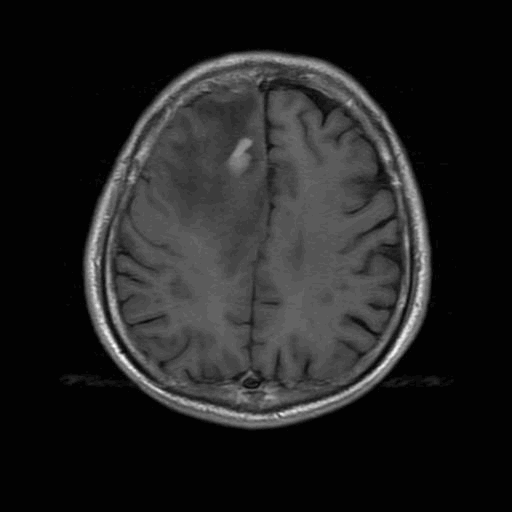

In [32]:
# generate prediction gif
imageio.plugins.freeimage.download()

anim_file = 'face_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))